# Hessians
- A lot of work trying to understand and explain deep loss landscapes relies on Hessians
- Here I compute NN hessians on a toy dataset, whith varying difficulty (noise)
- The point is to understand dynamics and possibly validate universality of findings in related works 
- Besides problem difficulty, other ablations include varying capacity (depth/width) [Sagun2016], comparing models with and without BN [Ghorbani2019, Yao2020] and looking at layer-wise hessians [Sankar2021]
- Hessian is computed naively, by brute force, as this work is just focused on the concept from scratch
- Followup work might include using specialised libraries to compute hessians of larger models
- My findings generally corraborate findings, however highlight that there is a problem and model specific element
    - Bulk-and-outlier distibution is always present, however outliers does not match num classes
    - Magnitude of eigenvalues decreases during training, but never diminish [Sagun2016]
    - Negative eigenvalues generally dissapear by end of training [Sagun16/18]
    - BN does not decrease magnitude of eigenvalues [Yao2020]
    - Individual layers show similar behaviour as full hessian [Sankar2021], including bn which can be computed a lot faster. Also seems negative eigs appear only multi-layer hessians
    - Increasing data difficulty generally increases magnitude of outliers [Sagun2016]
    - Unclear how capacity affects eigenspectrum, can't confirm findings that num outlier remains the same [Sagun2016]


# Example Run
- Decision boundary of model - dataset is failry noisy at 0.3 and can't be learned perfectly
- Validation accuracy and loss - model learns reasonably well and "converges"
- Max eigenvalue, trace initially increases but then decreases during training. Never diminishes
- Beginning of training there are negative hessian eigenvalues, which mostly dissapear by the end
- Eigenvalues display the famous bulk-and-outlier distribution, however outliers are generally more than number classes. Contrary to [Sagun2018, Ghorbani2019]


## Layerwise Analysis
- Negative eigenvalues emerge only when computing the hessian for parameters across multiple layers <-> no negative eigenvalues for individual layer hessians
    - Does non-convexity arise only because of joint optimisation of all layers? Consequently, is the optimisation of a single layer convex?
- Confirm findings of [Sankar2021] that layerwise hessian eigenspectra behave very similar to the full eigenspectrum
    - Very similar bulk and outlier distribution
    - Evolution very similar during training
    - There are exceptions, however not consistent. Sometimes first or last layers, sometimes middle ones
    - Multi-layer hessians (linear or bn only) are the most representative of full hessian
    - This can have some profound implications as BN-hessians are fast to compute


## w/wo BN
- To keep things comparable (not sure about this), computing hessian only over linear layers in both cases
- Contrary to [Ghorbani2019, Sankar2021], but in line with [Yao2020, Kaur2022] BN doesn't seem to lower max eig/trace in this setup. [Yao2020] argue BN lowers eigs only in deeper networks
- BN clearly helps training, but effect on eigenspectrum not clear


## Data Difficulty
- Based on [Sagun16] increasing dataset difficulty should increase magnitude of outlier eigenvalues, bulk should remain unchanged
- Largely true, with the exception of the smallest difficulty behaving differently
- Number of outlier eigenvalues seems to stay the same as well


## Capacity
- Based on [Sagun16/18] increasing capacity should only increase bulk/zero eigs but not the number of outliers. I can't replicate that
- Number and scale of eigenvalues within bulk increase with capacity
- Number of outlier eigenvalues increases with capacity
- There is no clear ordering of eigenspectra between capacities. It tends to go up with capacity, but there are outliers
- Same is true for different width/depth variations


## References
- [Sagun2016] Eigenvalues of the Hessian in Deep Learning: Singularity and Beyond - Sagun 2016
- [Sagun2018] Empirical analysis of the hessian of over-parametrized neural networks - Sagun 2018
- [Ghorbani2019] An investigation into neural net optimization via Hessian eigenvalue density - Ghorbani 2019
- [Sankar2021] A Deeper Look at the Hessian Eigenspectrum of Deep Neural Networks and its Applications to Regularization - Sankar 2021
- [Kaur2022] On the Maximum Hessian Eigenvalue and Generalization - Kaur 2022
- [Yao2020] PyHessian: Neural Networks through the Lens of the Hessian - Yao 2020

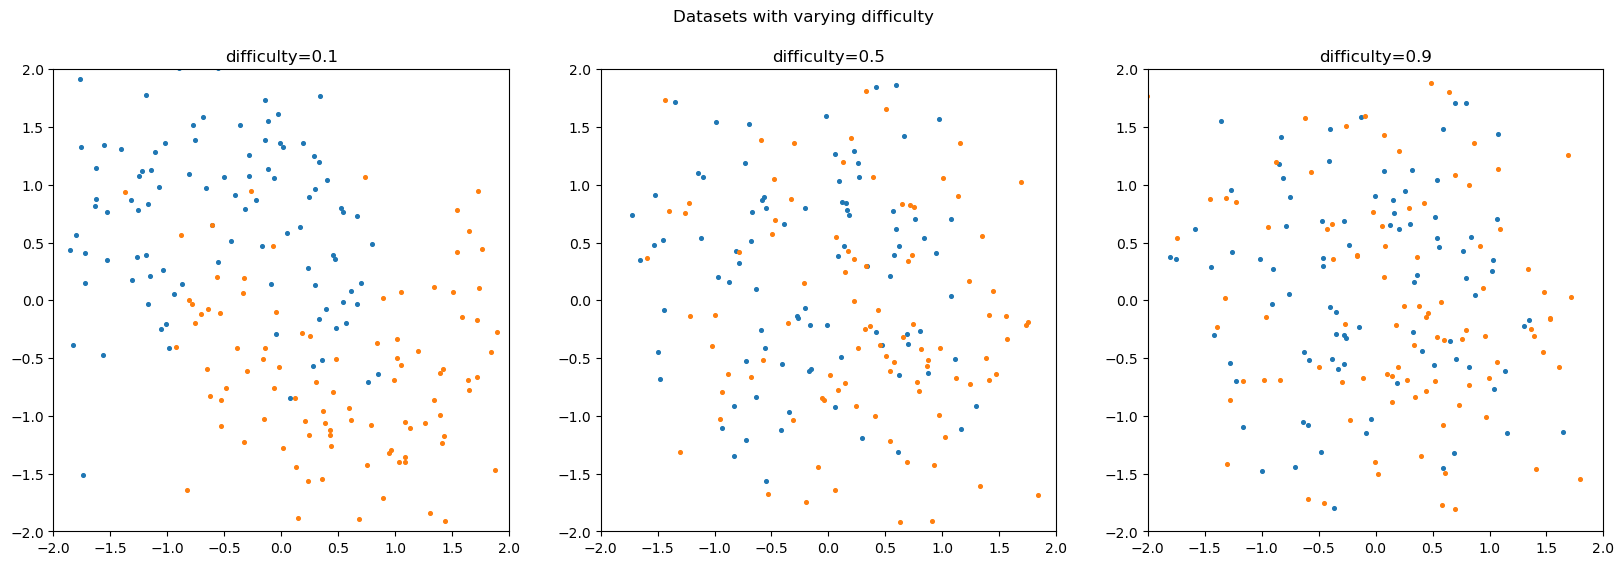

In [211]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from collections import defaultdict


def get_data(n_samples=200, difficulty=0.1):
    assert 0 <= difficulty <= 1, "difficulty must be in [0, 1]"
    difficulty = difficulty * 3
    X, y = make_moons(n_samples=n_samples, noise=difficulty, random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

def plot_data(X, y, ax=None, title="", alpha=1):
    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], s=7, alpha=alpha)
    ax.scatter(X[:,0][y==1], X[:,1][y==1], s=7, alpha=alpha)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_title(title)

fig, axarr = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Datasets with varying difficulty")
plot_data(*get_data(difficulty=0.1), ax=axarr[0], title="difficulty=0.1")
plot_data(*get_data(difficulty=0.5), ax=axarr[1], title="difficulty=0.5")
plot_data(*get_data(difficulty=0.9), ax=axarr[2], title="difficulty=0.9")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from torch import Tensor
from typing import List
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


def get_dataset(n_samples=1000, difficulty=0.0, split=0.5):
    X, y = get_data(n_samples=n_samples, difficulty=difficulty)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=split, random_state=0
    )
    X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(y_train, dtype=torch.long).cuda()
    X_val = torch.tensor(X_val, dtype=torch.float32).cuda()
    y_val = torch.tensor(y_val, dtype=torch.long).cuda()
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    return train_ds, val_ds


def plot_decision_boundary(model, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()

    model.eval().cpu()
    Z = model(grid).softmax(axis=1)[:, 0].detach().numpy()
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)


In [3]:
def get_model(arch: str, bn=True):
    """Arch like "3/100" for 3 layers of 100 neurons each."""
    depth, width = [int(x) for x in arch.split("/")]
    layers = []
    for depth_ in range(depth):
        layers.append(nn.Linear(2 if depth_ == 0 else width, width))
        if bn:
            layers.append(nn.BatchNorm1d(width))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(width, 2))
    model = nn.Sequential(*layers)
    init_model(model)
    return model


def get_params(model, layers="all") -> list:
    """
    convenience function to get layers from a model
    layers can include :idx to get a specific layer, None if all layers and all classes
    """
    res = []
    if layers == "all":
        return list(model.parameters())
    
    idx = None
    if ":" in layers:
        layers, idx = layers.split(":")
        idx = int(idx)
    for m in model.modules():
        if layers == "linear" and isinstance(m, nn.Linear):
            res.append(m)
        if layers == "bn" and isinstance(m, nn.BatchNorm1d):
            res.append(m)
    if idx is not None:
        res = [res[idx]]
    res = [p for m in res for p in m.parameters()]
    return res

def init_model(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

In [4]:
def compute_hessian_eigs(model, X, y, layers=None) -> np.array:
    """Naive, brute force computation of the Hessian eigenvalues."""
    criterion = nn.CrossEntropyLoss()
    out = model(X)
    loss = criterion(out, y)
    params: List[Tensor] = get_params(model, layers=layers)
    grads1: List[Tensor] = torch.autograd.grad(loss, params, create_graph=True)
    grads1: Tensor = torch.concat([g.flatten() for g in grads1]) # vector
    hessian = []
    for grad1 in grads1:
        # Note: autograd.grad requires a scalaer, so we need to go one gradient at a time
        grads2 = torch.autograd.grad(grad1, params, retain_graph=True)
        grads2 = torch.concat([g.flatten() for g in grads2]) # vector
        hessian.append(grads2)
    
    H = torch.stack(hessian, dim=1)
    H = H.detach().cpu().numpy()
    eigvals = np.linalg.eigvals(H).real
    return eigvals

In [197]:
def trainer(n_epochs=100, arch="3/30", batch_size=32, difficulty=0.0, bn=True, grad_layers="all", plot=False, ax=None) -> float:
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    
    logs = defaultdict(list)
    time_start = time.time()
    
    # Data
    train_ds, val_ds = get_dataset(n_samples=1000, difficulty=difficulty)
    val_X, val_y = val_ds.tensors
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Model
    model = get_model(arch, bn).cuda()

    # Optim
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

    # Train
    for epoch in range(n_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimiser.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimiser.step()

        # Evaluate
        model.eval()
        accuracy = Accuracy(task="multiclass", num_classes=2).cuda()
        with torch.no_grad():
            outputs = model(val_X)
            acc = accuracy(outputs, val_y).item()
            logs["val_acc"].append(acc)
            loss = criterion(outputs, val_y).item()
            logs["val_loss"].append(loss)

        if grad_layers is not None:
            hessian_eigs = compute_hessian_eigs(model, *train_ds.tensors, layers=grad_layers)
            logs["hess_eigs"].append(hessian_eigs)

    logs["time"] = time.time() - time_start
    if plot:
        plot_decision_boundary(model, ax)
    return logs

# Example Run
- Decision boundary of model - dataset is failry noisy at 0.3 and can't be learned perfectly
- Validation accuracy and loss - model learns reasonably well and "converges"
- Max eigenvalue, trace initially increases but then decreases during training. Never diminishes
- Beginning of training there are negative hessian eigenvalues, which mostly dissapear by the end
- Eigenvalues display the famous bulk-and-outlier distribution, however outliers are generally more than number classes. Contrary to [Sagun2018, Ghorbani2019]

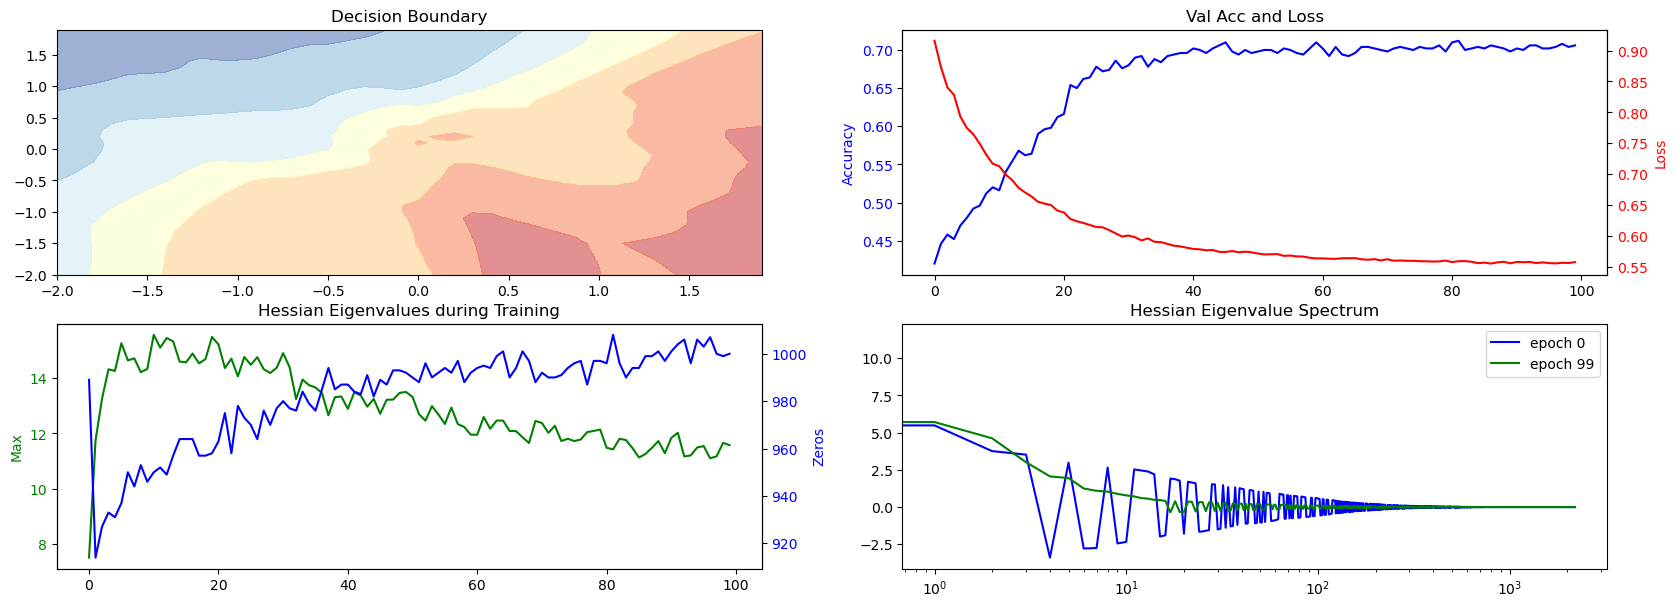

In [212]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))
axs[0, 0].set_title("Decision Boundary")
res = trainer(arch="3/30", n_epochs=100, grad_layers="all", difficulty=0.3, plot=True, ax=axs[0, 0])

axs[0, 1].set_title("Val Acc and Loss")
axs[0, 1].plot(res["val_acc"], color="blue")
axs[0, 1].set_ylabel("Accuracy", color="blue")
axs[0, 1].tick_params(axis="y", labelcolor="blue")
axs_ = axs[0, 1].twinx()
axs_.plot(res["val_loss"], color="red")
axs_.set_ylabel("Loss", color="red")
axs_.tick_params(axis="y", labelcolor="red")

axs[1, 0].set_title("Hessian Eigenvalues during Training")
axs[1, 0].plot([eigs[0] for eigs in res["hess_eigs"]], color="green")
axs[1, 0].set_ylabel("Max", color="green")
axs[1, 0].tick_params(axis="y", labelcolor="green")
axs_ = axs[1, 0].twinx()
axs_.plot([sum(abs(eigs) < 1e-4) for eigs in res["hess_eigs"]], color="blue")
axs_.set_ylabel("Zeros", color="blue")
axs_.tick_params(axis="y", labelcolor="blue")

axs[1, 1].set_title("Hessian Eigenvalue Spectrum")
axs[1, 1].plot(res["hess_eigs"][0], label="epoch 0", color="blue")
axs[1, 1].plot(res["hess_eigs"][-1], label="epoch 99", color="green")
axs[1, 1].legend()
axs[1, 1].set_xscale("log")

plt.show()


# Layerwise Analysis
- Negative eigenvalues emerge only when computing the hessian for parameters across multiple layers <-> no negative eigenvalues for individual layer hessians
    - Does non-convexity arise only because of joint optimisation of all layers? Consequently, is the optimisation of a single layer convex?
- Confirm findings of [Sankar2021] that layerwise hessian eigenspectra behave very similar to the full eigenspectrum
    - Very similar bulk and outlier distribution
    - Evolution very similar during training
    - There are exceptions, however not consistent. Sometimes first or last layers, sometimes middle ones.
    - Multi-layer hessians (linear or bn only) are the most representative of full hessian
    - This can have some profound implications as BN-hessians are fast to compute

In [200]:
res_layers = dict()

grad_layers = ["linear:0", "linear:1", "linear:2", "linear:3", "linear", "bn:0", "bn:1", "bn:2", "bn", "all"]
for grad_layer in grad_layers:
    res_layers[grad_layer] = trainer(arch="3/30", n_epochs=100, grad_layers=grad_layer, difficulty=0.3)

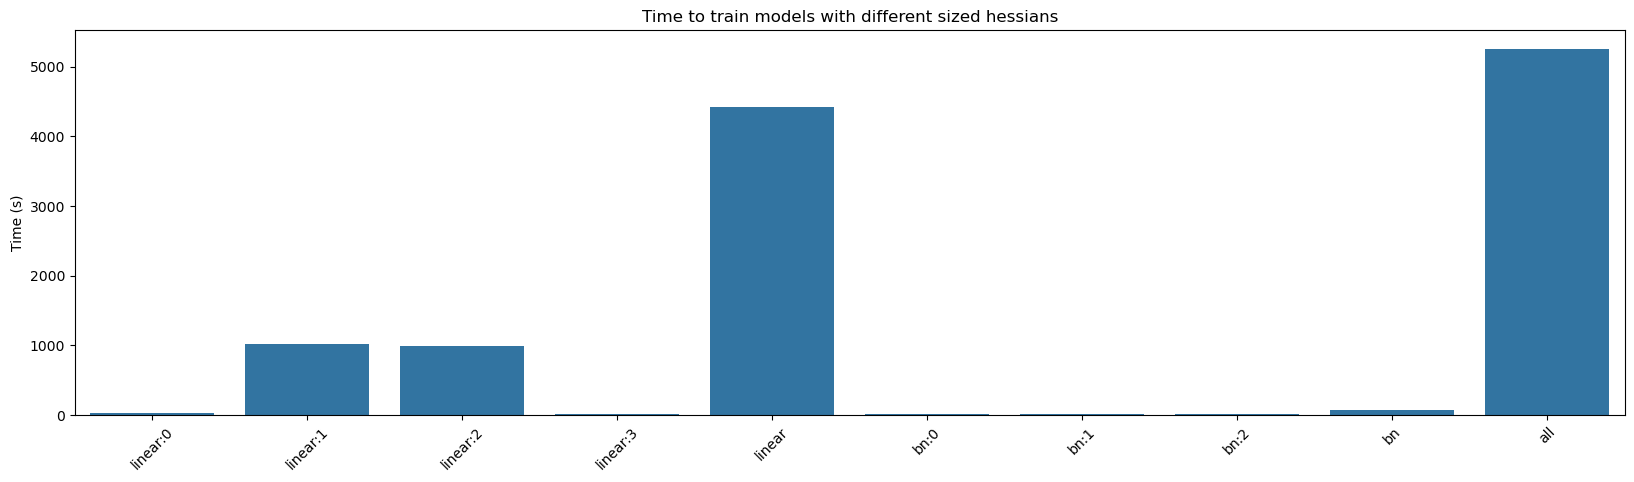

In [207]:
times = [res_layers[grad_layer]["time"] for grad_layer in grad_layers]
plt.figure(figsize=(20, 5))
sns.barplot(x=grad_layers, y=times)
plt.title("Time to train models with different sized hessians")
plt.ylabel("Time (s)")
plt.xticks(rotation=45)
plt.show()

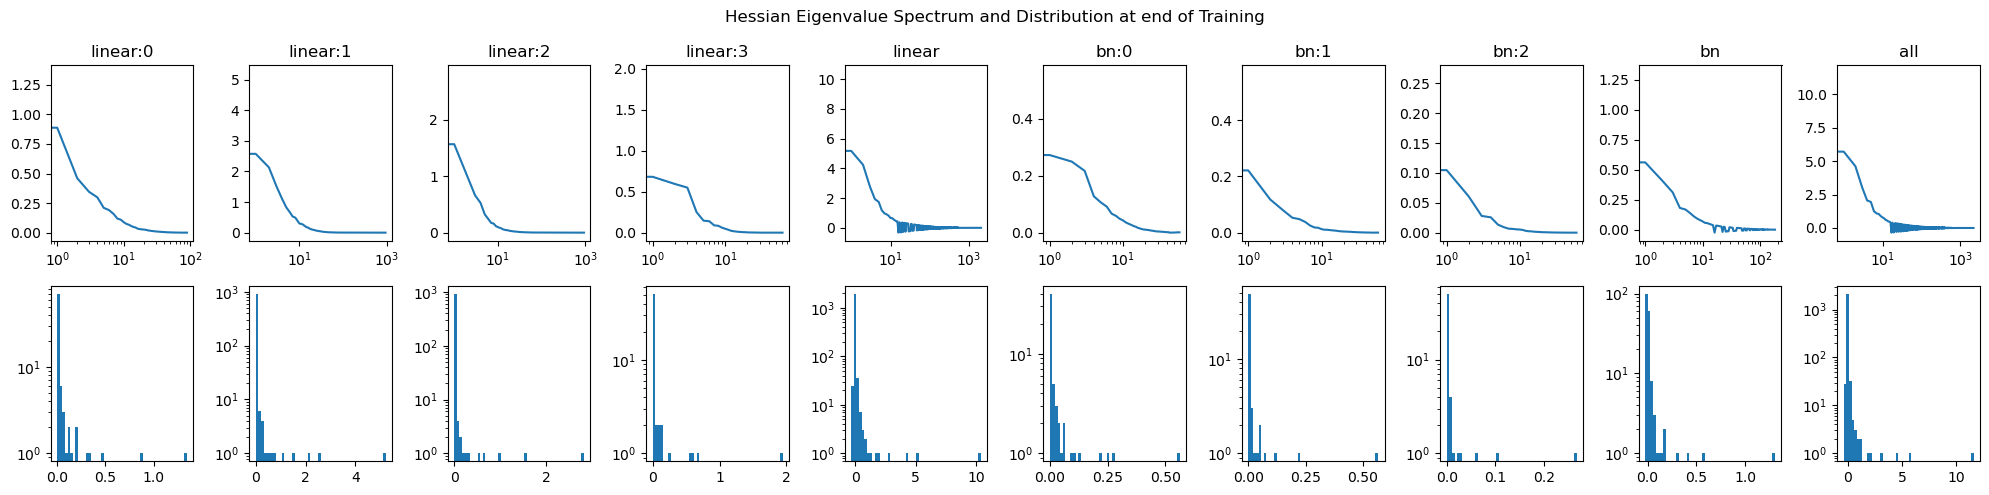

In [209]:
fig, axs = plt.subplots(2, len(res_layers), figsize=(20, 5))
fig.suptitle("Hessian Eigenvalue Spectrum and Distribution at end of Training")
for i, (grad_layer, logs) in enumerate(res_layers.items()):
    axs[0, i].set_title(grad_layer)
    axs[0, i].plot(logs["hess_eigs"][-1])
    axs[0, i].set_xscale("log")
    axs[1, i].hist(logs["hess_eigs"][-1], bins=50)
    axs[1, i].set_yscale("log")
plt.tight_layout()
plt.show()

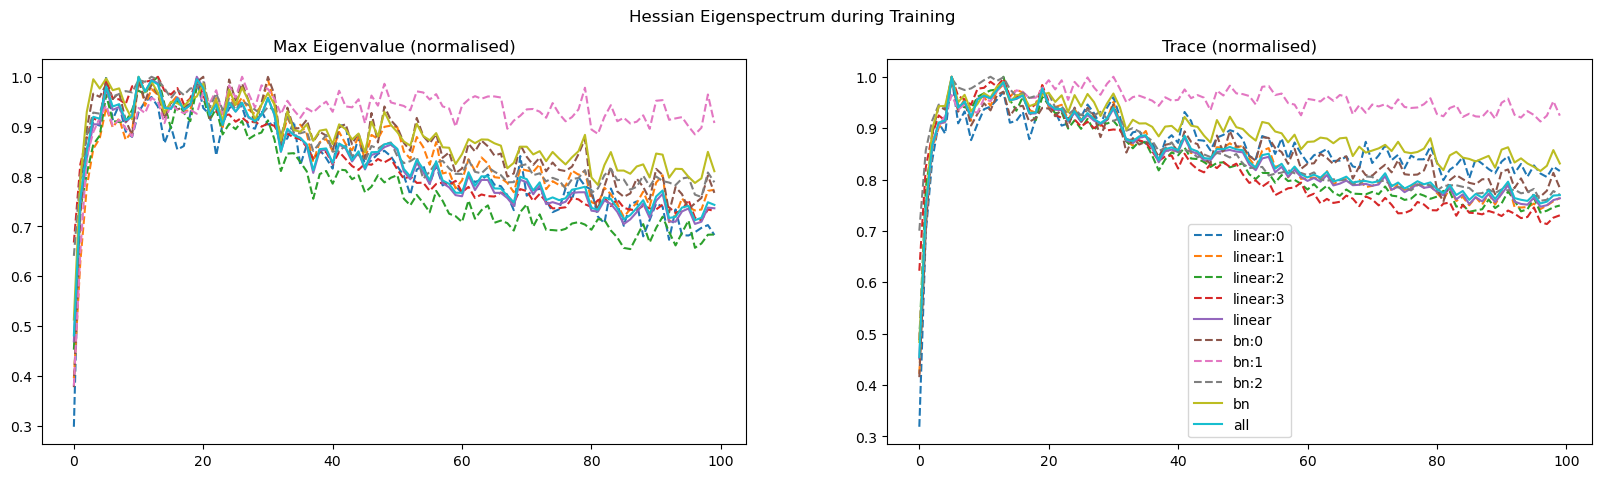

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Hessian Eigenspectrum during Training")

for i, (grad_layer, logs) in enumerate(res_layers.items()):
    linestyle = "-" if ":" not in grad_layer else "--"

    max_eigs = [eigs[0] for eigs in logs["hess_eigs"]]
    axs[0].plot(max_eigs / max(max_eigs), label=grad_layer, linestyle=linestyle)
    axs[0].set_title("Max Eigenvalue (normalised)")

    sum_eigs = [np.sum(eigs) for eigs in logs["hess_eigs"]]
    axs[1].plot(sum_eigs / max(sum_eigs), label=grad_layer, linestyle=linestyle)
    axs[1].set_title("Trace (normalised)")
plt.legend()
plt.show()

# w/wo BN
- To keep things comparable (not sure about this), computing hessian only over linear layers in both cases
- Contrary to [Ghorbani2019, Sankar2021], but in line with [Yao2020, Kaur2022] BN doesn't seem to lower max eig/trace in this setup. [Yao2020] argue BN lowers eigs only in deeper networks.
- BN clearly helps training, but effect on eigenspectrum not clear

In [ ]:
res_bn = dict()
res_bn["bn"] = trainer(arch="3/30", n_epochs=100, grad_layers="linear", difficulty=0.3, bn=True)
res_bn["no_bn"] = trainer(arch="3/30", n_epochs=100, grad_layers="linear", difficulty=0.3, bn=False)

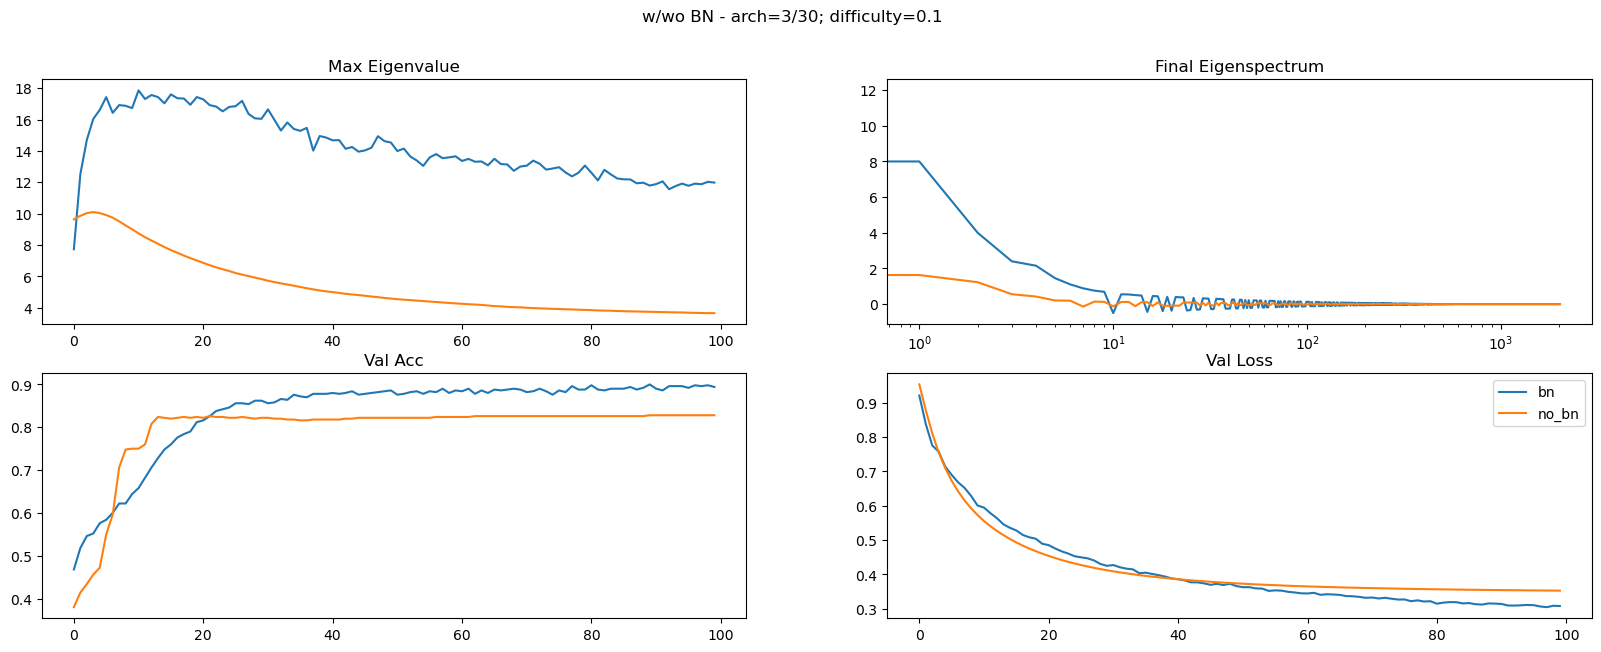

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))
fig.suptitle("w/wo BN - arch=3/30; difficulty=0.1")

for key, logs in res_bn.items():
    axs[0, 0].plot([np.max(eigs) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 0].set_title("Max Eigenvalue")

    axs[0, 1].plot(logs["hess_eigs"][-1], label=key)
    axs[0, 1].set_title("Final Eigenspectrum")
    axs[0, 1].set_xscale("log")

    axs[1, 0].plot(logs["val_acc"], label=key)
    axs[1, 0].set_title("Val Acc")

    axs[1, 1].plot(logs["val_loss"], label=key)
    axs[1, 1].set_title("Val Loss")
plt.legend()
plt.show()

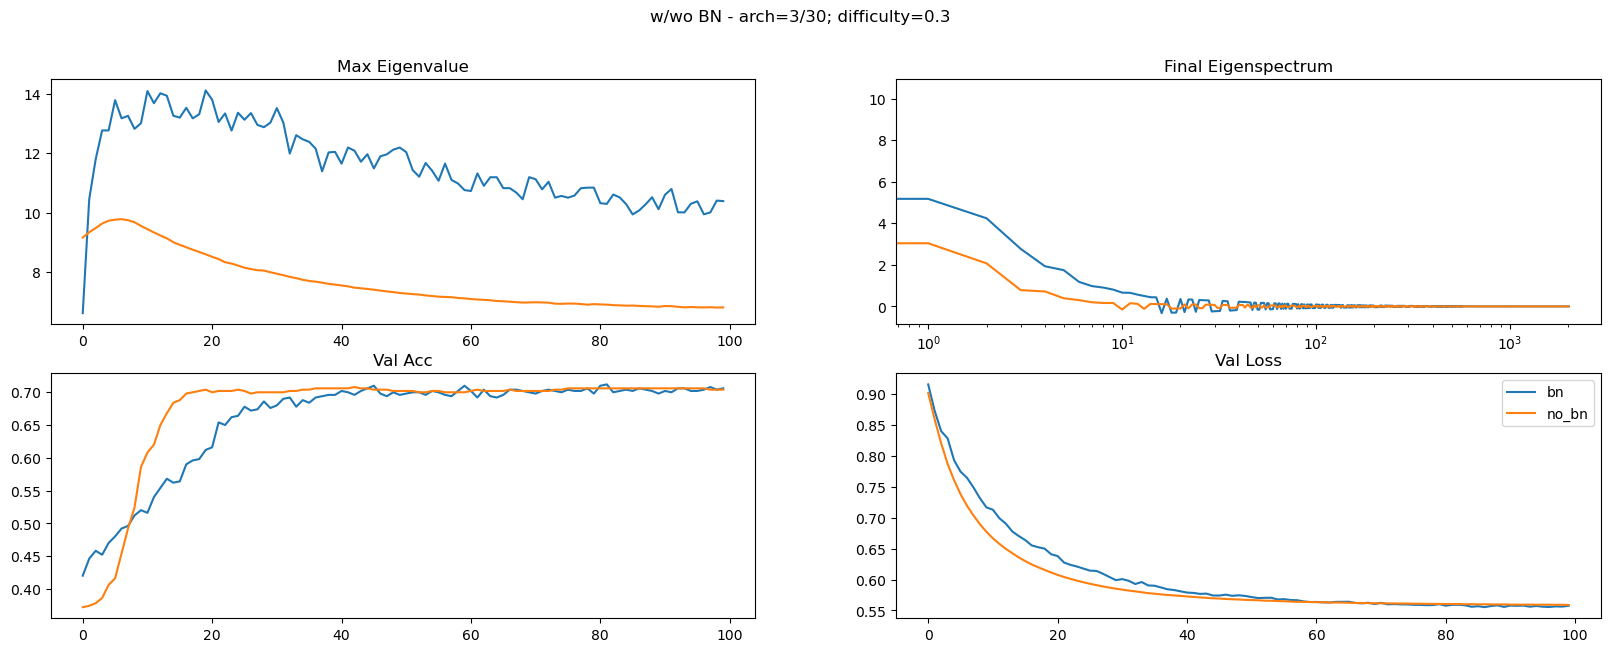

In [186]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))
fig.suptitle("w/wo BN - arch=3/30; difficulty=0.3")

for key, logs in res_bn.items():
    axs[0, 0].plot([np.max(eigs) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 0].set_title("Max Eigenvalue")

    axs[0, 1].plot(logs["hess_eigs"][-1], label=key)
    axs[0, 1].set_title("Final Eigenspectrum")
    axs[0, 1].set_xscale("log")

    axs[1, 0].plot(logs["val_acc"], label=key)
    axs[1, 0].set_title("Val Acc")

    axs[1, 1].plot(logs["val_loss"], label=key)
    axs[1, 1].set_title("Val Loss")
plt.legend()
plt.show()

# Data Difficulty
- Based on [Sagun16] increasing dataset difficulty should increase magnitude of outlier eigenvalues, bulk should remain unchanged.
- Largely true, with the exception of the smallest difficulty behaving differently.
- Number of outlier eigenvalues seems to stay the same as well.

In [120]:
res_noise = dict()
for noise in [0.1, 0.3, 0.5, 0.7, 0.9]:
    res_noise[noise] = trainer(arch="3/30", n_epochs=100, difficulty=noise, grad_layers="all")

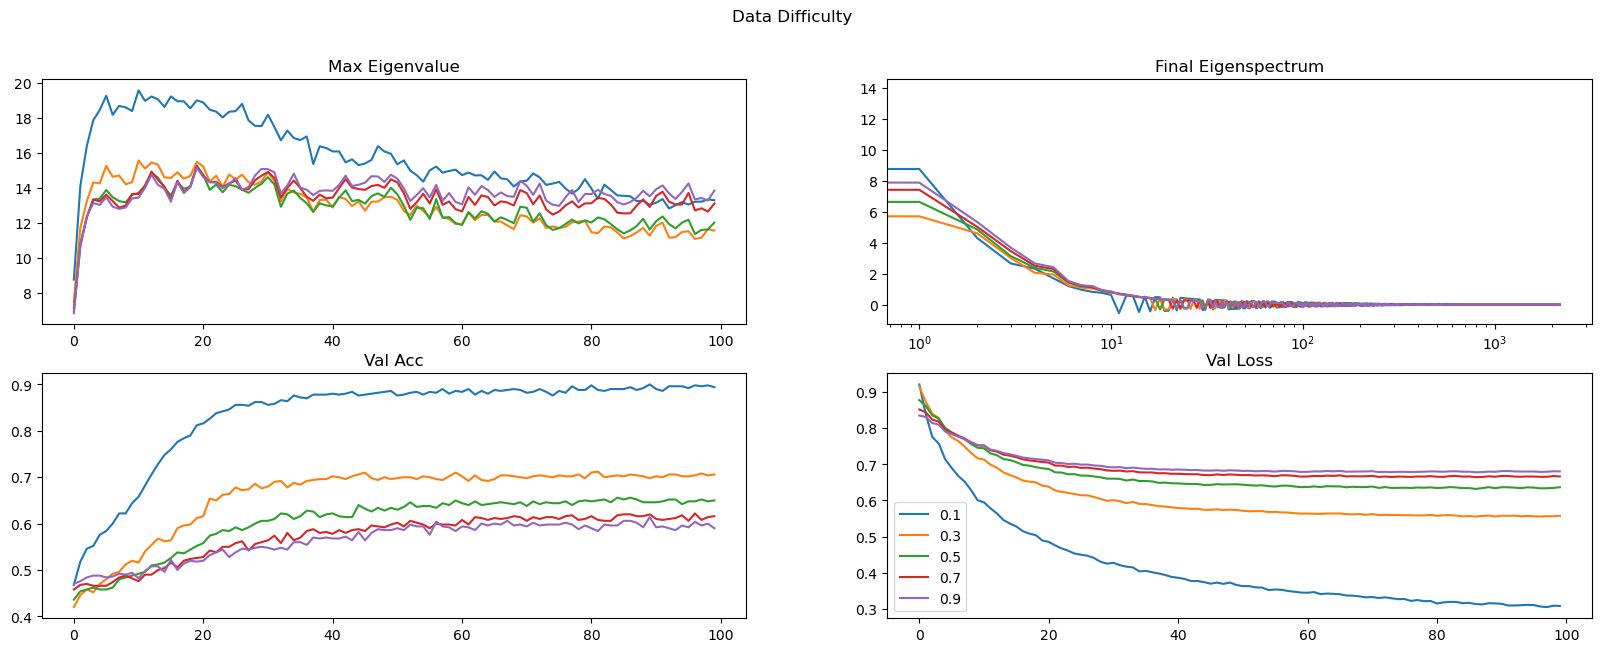

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))
fig.suptitle("Data Difficulty")

for key, logs in res_noise.items():
    axs[0, 0].plot([np.max(eigs) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 0].set_title("Max Eigenvalue")

    axs[0, 1].plot(logs["hess_eigs"][-1], label=key)
    axs[0, 1].set_title("Final Eigenspectrum")
    axs[0, 1].set_xscale("log")

    axs[1, 0].plot(logs["val_acc"], label=key)
    axs[1, 0].set_title("Val Acc")

    axs[1, 1].plot(logs["val_loss"], label=key)
    axs[1, 1].set_title("Val Loss")
plt.legend()
plt.show()

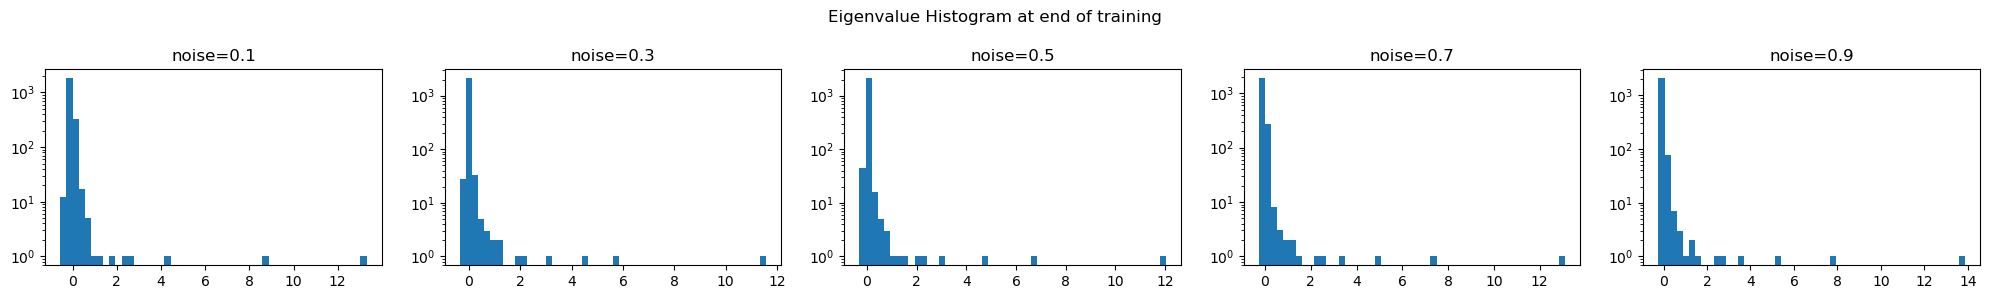

In [218]:
fig, axs = plt.subplots(1, len(res_noise), figsize=(20, 3))
fig.suptitle("Eigenvalue Histogram at end of training")

for i, (key, logs) in enumerate(res_noise.items()):
    axs[i].hist(logs["hess_eigs"][-1], bins=50)
    axs[i].set_yscale("log")
    axs[i].set_title(f"noise={key}")

plt.tight_layout()

# Capacity
- Based on [Sagun16/18] increasing capacity should only increase bulk/zero eigs but not the number of outliers. I can't replicate that.
- Number and scale of eigenvalues within bulk increase with capacity
- Number of outlier eigenvalues increases with capacity
- There is no clear ordering of eigenspectra between capacities. It tends to go up with capacity, but there are outliers.
- Same is true for different width/depth variations.

In [145]:
res_arch = dict()
for arch in ["1/10", "2/20", "3/30", "4/40"]:
    res_arch[arch] = trainer(arch=arch, n_epochs=100, difficulty=0.3, grad_layers="all")

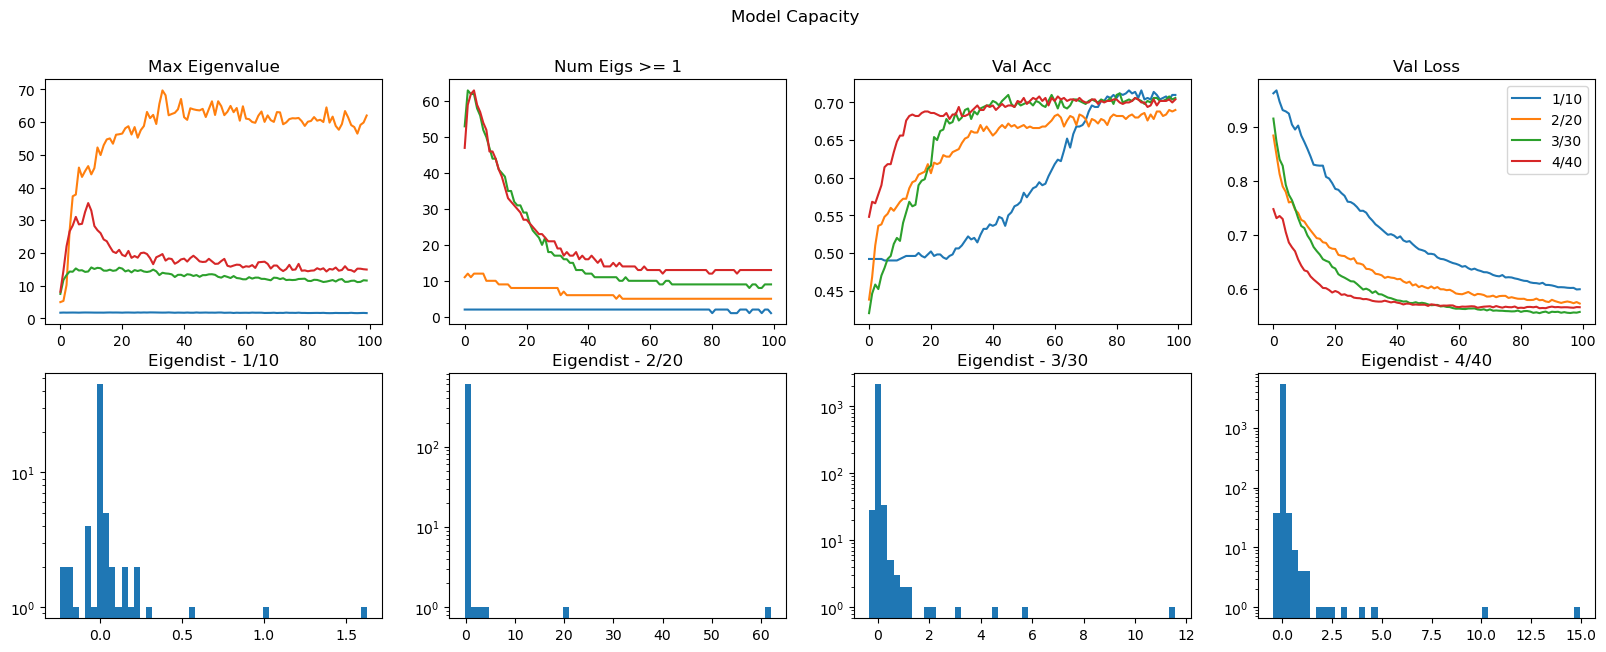

In [182]:
fig, axs = plt.subplots(2, 4, figsize=(20, 7))
fig.suptitle("Model Capacity")

for ix, key in enumerate(["1/10", "2/20", "3/30", "4/40"]):
    logs = res_arch[key]

    axs[0, 0].plot([np.max(eigs) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 0].set_title("Max Eigenvalue")

    axs[0, 1].plot([np.sum(abs(eigs) >= 1) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 1].set_title("Num Eigs >= 1")
    # axs[0, 1].set_xscale("log")

    axs[0, 2].plot(logs["val_acc"], label=key)
    axs[0, 2].set_title("Val Acc")

    axs[0, 3].plot(logs["val_loss"], label=key)
    axs[0, 3].set_title("Val Loss")
    axs[0, 3].legend()


    axs[1, ix].hist(logs["hess_eigs"][-1], bins=50)
    axs[1, ix].set_yscale("log")
    axs[1, ix].set_title(f"Eigendist - {key}")

plt.show()

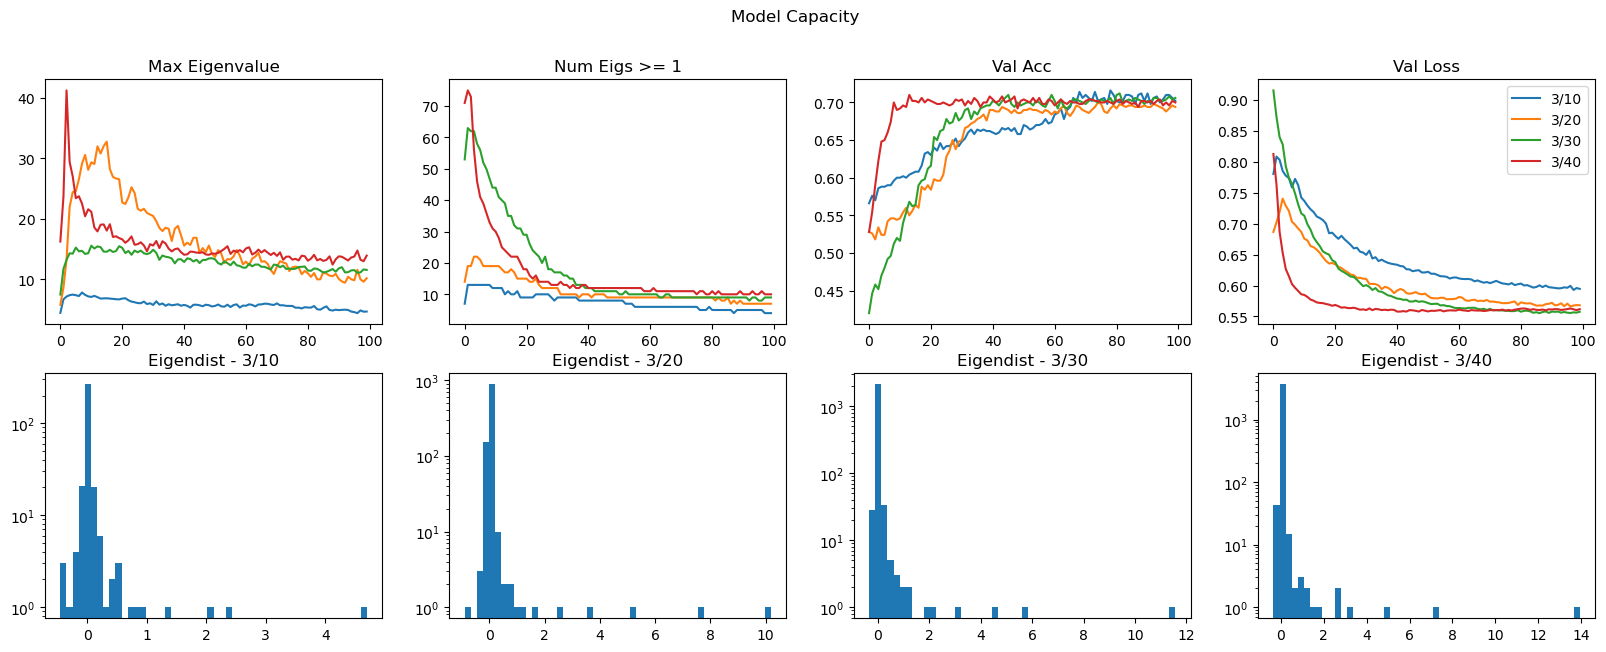

In [183]:
fig, axs = plt.subplots(2, 4, figsize=(20, 7))
fig.suptitle("Model Capacity")

for ix, key in enumerate(["3/10", "3/20", "3/30", "3/40"]):
    logs = res_arch[key]

    axs[0, 0].plot([np.max(eigs) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 0].set_title("Max Eigenvalue")

    axs[0, 1].plot([np.sum(abs(eigs) >= 1) for eigs in logs["hess_eigs"]], label=key)
    axs[0, 1].set_title("Num Eigs >= 1")
    # axs[0, 1].set_xscale("log")

    axs[0, 2].plot(logs["val_acc"], label=key)
    axs[0, 2].set_title("Val Acc")

    axs[0, 3].plot(logs["val_loss"], label=key)
    axs[0, 3].set_title("Val Loss")
    axs[0, 3].legend()


    axs[1, ix].hist(logs["hess_eigs"][-1], bins=50)
    axs[1, ix].set_yscale("log")
    axs[1, ix].set_title(f"Eigendist - {key}")

plt.show()